# DIFFERENTIAL CONTROL

# Is rateOf implemened correctly?

In [2]:
import controlSBML as ctl

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
ctl.__version__

'1.1.04'

# Evaluate rateOf

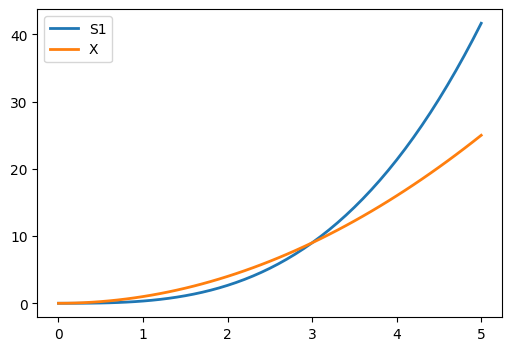

In [2]:
MODEL = """
-> S1; time*time
X := rateOf(S1)
"""
rr = te.loada(MODEL)
rr.simulate(selections=["time", "S1", "X"])
rr.plot()

# Analysis of Linear Model

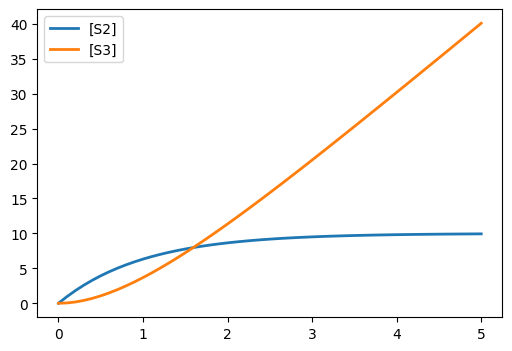

In [3]:
LINEAR_MODEL = """
model *main()
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

k1 = 1
k2 = 1
S1 =10
s2 = 10
end
"""
rr = te.loada(LINEAR_MODEL)
rr.simulate()
rr.plot()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


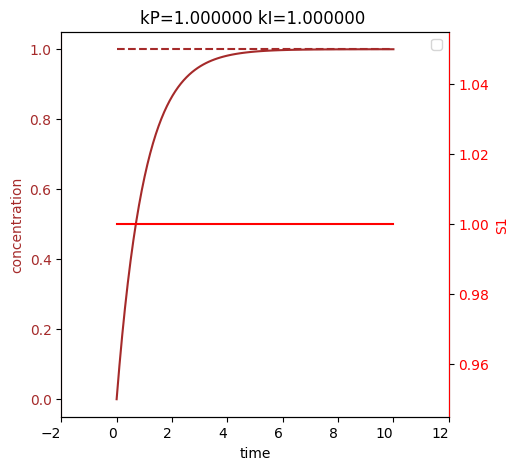

In [4]:
CTLSB_LINEAR = ctl.ControlSBML(LINEAR_MODEL, input_name="S1", output_name="S2")
result = CTLSB_LINEAR.plotDesign(kI_spec=1, kP_spec=1)

In [5]:
result.antimony_builder

// Created by libAntimony v2.13.2
model *main()

  // Compartments and Species:
  species $S1, S2, S3;

  // Reactions:
  _J0: $S1 -> S2; k1*S1;
  _J1: S2 -> S3; k2*S2;

  // Species initializations:
  S1 = 10;
  S2 = ;
  S3 = ;

  // Variable initializations:
  k1 = 1;
  k2 = 1;
  s2 = 10;

  // Other declarations:
  const k1, k2, s2;

//vvvvvvvvvAdded by ControlSBMLvvvvvvvvvv

// Closed loop: S1 -> S2

// Make sinusoid: amplitude=0, frequency=20
noise_S1_S2_ot := 0.000000*sin(2*pi*20.000000*time)

// Make sinusoid: amplitude=0, frequency=20
disturbance_S1_S2_ot := 0.000000*sin(2*pi*20.000000*time)

// Filter: kF=None
filter_S1_S2_ot := filter_S1_S2_in

// PI Controller: kP=1.0, kI=1.0
controller_integral_error_S1_S2' = controller_S1_S2_in
controller_integral_error_S1_S2 = 0
controller_S1_S2_ot := 1.000000*controller_S1_S2_in+ 1.000000*controller_integral_error_S1_S2
control_error_S1_S2_ot := 1 - filter_S1_S2_ot

// Connect the elements of the closed loop
controller_S1_S2_in := contro

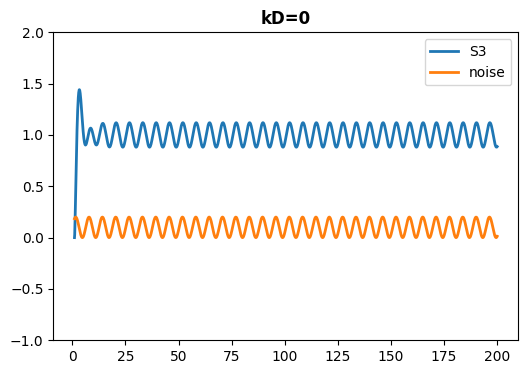

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 68.6596 and h = 1.58282e-20, the corrector convergence test failed repeatedly or with |h| = hmin.


RuntimeError: CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)

In [23]:
PID_CONTROL = """
// Created by libAntimony v2.13.2
model *main()

  // Compartments and Species:
  species $S1, S2, S3;

  // Reactions:
  _J0: $S1 -> S2; k1*S1;
  _J1: S2 -> S3; k2*S2;
  _J2: S3 -> S2; k3*S3

  // Species initializations:
  S1 = 10;
  S2 = ;
  S3 = ;

  // Variable initializations:
  k1 = 2;
  k2 = 3;
  s2 = 10;
  k3 = 4

// Closed loop: S1 -> S3

// PI Controller: kP=1.0, kI=1.0
kP_S1_S3 = 1.0
kI_S1_S3 = 1.0
kD_S1_S3 = 1.0
kF = 100
setpoint_S1_S3 = 1

filter = 0
filter' = kF*S3 - kF*filter

control_error_S1_S3 := setpoint_S1_S3 - filter
integral_control_error_S1_S3' = control_error_S1_S3
integral_control_error_S1_S3 = 0
#derivative_control_error_S1_S3 := -rateOf(S3)
derivative_control_error_S1_S3 := -kF*S3 - kF*filter
noise := 0.1*sin(time) + 0.1

# PID with noise
S1 := kP_S1_S3*control_error_S1_S3 + kI_S1_S3*integral_control_error_S1_S3 + kD_S1_S3*derivative_control_error_S1_S3 + noise
end
"""
ylim = [-1, 2]
rr = te.loada(PID_CONTROL)
rr["kD_S1_S3"] = 0
rr.simulate(1, 200, 2000, selections=["time", "S3", "noise"])
rr.plot(title="kD=0", ylim=ylim)
rr["kD_S1_S3"] = 10
rr.reset()
rr.simulate(1, 200, 2000, selections=["time", "S3", "noise"])
rr.plot(title="kD=10", ylim=ylim)

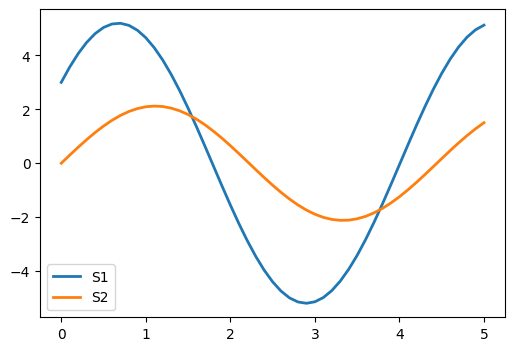

In [7]:
# A simpler example

EXPANDED_LINEAR_MODEL = """
// Created by libAntimony v2.13.2

  // Reactions:
  _J0: $S1 -> S2; k1*S1;
  _J1: S2 -> S3; k2*S2;

  // Species initializations:
  S1 = 10;
  S2 = 0;
  S3 = 0;

  // Variable initializations:
  k1 = 1;
  k2 = 2;
  kP = 1
  kD = 1
  setpoint = 3

  err := setpoint - S3
  $S1 := kP*err + kD*rateOf(S3)
"""
rr = te.loada(EXPANDED_LINEAR_MODEL)
rr.simulate(selections=["time", "S1", "S2"])
rr.plot()

# Model 2

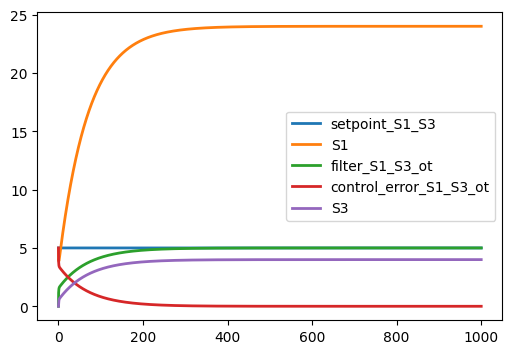

In [38]:
MODEL2 = """
model *main_model()

S1 -> S2; k1*S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 1
k2 = 2
k3 = 3
k4 = 4
S1 = 10
S2 = 0
S3 = 0


//^^^^^^^^^Added by ControlSBML^^^^^^^^^^
const S1

// **CREATING CLOSED LOOP SYSTEM**
setpoint_S1_S3 = 5
S3 = 0.0

// Make sinusoid: amplitude=1, frequency=2
noise_S1_S3_ot := 0*sin(2*pi*2.000000*time) + 1.000000

// Make sinusoid: amplitude=2, frequency=3
disturbance_S1_S3_ot := 0

// Make filter: kF=0.1

// Filter: kF=0.1
kF = 1e3
 -> filter_S1_S3_ot; -kF*filter_S1_S3_ot + kF*filter_S1_S3_in 
filter_S1_S3_ot = 0

// Make the PID controller
controller_kP_S1_S3 = 1
controller_kI_S1_S3 = 0.1
controller_kD_S1_S3 = 2
controller_derivative_error_S1_S3 := -1*(-0.100000*filter_S1_S3_ot + 0.100000*filter_S1_S3_in)
controller_integral_error_S1_S3' = controller_S1_S3_in
controller_integral_error_S1_S3 = 0
controller_S1_S3_ot := controller_kP_S1_S3*controller_S1_S3_in + controller_kI_S1_S3*controller_integral_error_S1_S3 + controller_kD_S1_S3*controller_derivative_error_S1_S3

// Make the control error
control_error_S1_S3_ot := setpoint_S1_S3 - filter_S1_S3_ot

// Connect the elements of the closed loop
controller_S1_S3_in := control_error_S1_S3_ot
S1 := controller_S1_S3_ot + disturbance_S1_S3_ot
filter_S1_S3_in := S3 + noise_S1_S3_ot
end
"""
rr = te.loada(MODEL2)
rr.simulate(0, 1000, 10000, selections=["time", "setpoint_S1_S3", "S1", "filter_S1_S3_ot", "control_error_S1_S3_ot", "S3"])
rr.plot()

# Random

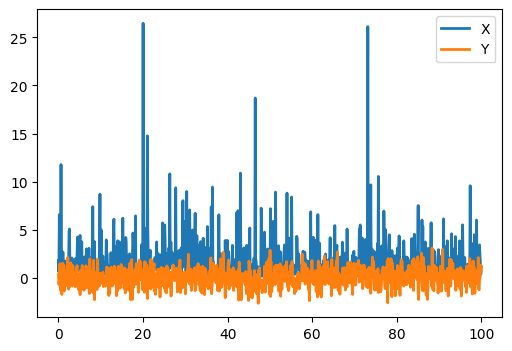

In [97]:
MODEL = """
//S1 -> S2; time*time
X := lognormal(0, 1)
Y := log(X)
"""
rr = te.loada(MODEL)
data = rr.simulate(0, 100, 1000, selections=["time", "X", "Y"])
rr.plot()

In [99]:
np.std(data["Y"])

0.9876760653433363

# Assess equivalence of reaction and species

This equivalence works well for smooth functions, such as sine.

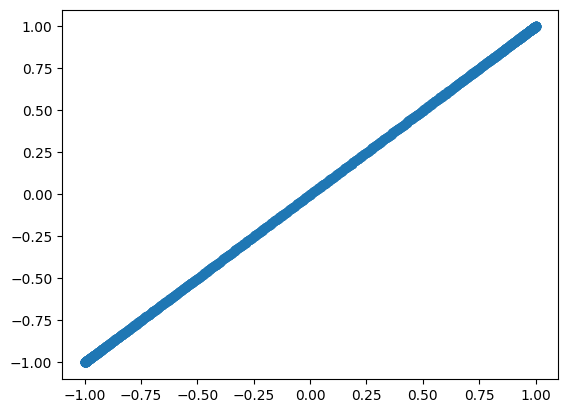

In [13]:
model = """
k1 := sin(100*time)
J1: S2->S2; k1
S2 = 1
"""
rr = te.loada(model)
selections = ["time", "k1", "J1"]
data = rr.simulate(0, 100, 1000, selections=selections)
plt.scatter(data["k1"], data["J1"])

But it works poory if $k_1$ is purely random. Suppose $k_1 = a t + e(t)$, where
$log(e(t))$ is $N(0, 1)$.

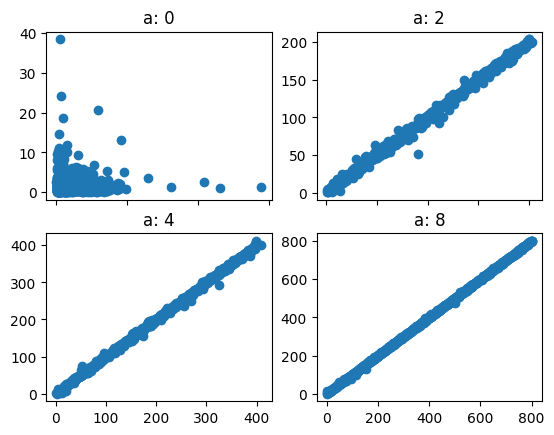

In [19]:
model = """
k1 := lognormal(0, 1) + a*time
J1: S2->S2; k1
S2 = 1
a = 0
"""
_, axes = plt.subplots(2, 2)
pos_dct = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
for idx, a in enumerate([0, 2, 4, 8]):
    ax = axes[pos_dct[idx]]
    rr = te.loada(model)
    rr["a"] = a
    selections = ["time", "k1", "J1"]
    data = rr.simulate(0, 100, 1000, selections=selections)
    ax.scatter(data["k1"], data["J1"])
    ax.set_title(f"a: {a}")
    if idx < 2:
        ax.set_xticklabels([])

# rateOf for a random variable

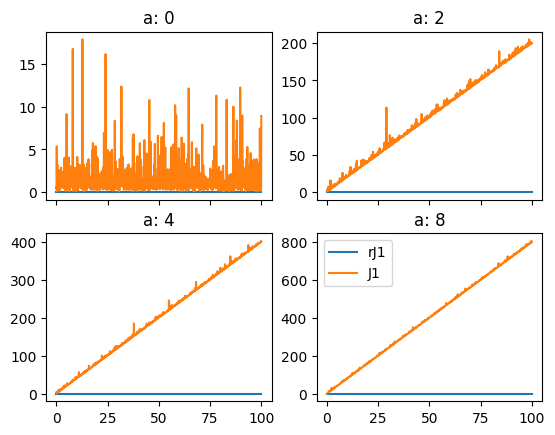

In [31]:
model = """
k1 := lognormal(0, 1) + a*time
J1: S1->S1; k1
rJ1 := rateOf(J1)
S1 = 1
a = 0
"""
_, axes = plt.subplots(2, 2)
pos_dct = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
for idx, a in enumerate([0, 2, 4, 8]):
    ax = axes[pos_dct[idx]]
    rr = te.loada(model)
    rr["a"] = a
    selections = ["time", "k1", "J1", "rJ1"]
    data = rr.simulate(0, 100, 1000, selections=selections)
    ax.plot(data["time"], data["rJ1"])
    ax.plot(data["time"], data["J1"])
    ax.set_title(f"a: {a}")
    if idx < 2:
        ax.set_xticklabels([])
    if idx == 3:
        ax.legend(["rJ1", "J1"])